# Fraud detection test task

## Solution overview 

### 1. Review data 
*Исследовать данные, найти потенциальные аномалии и другие проблемы в данных.*
- missed values of `city`, `isp`, `ip_address`
- some conversations have no record with `activity_kind` == `install`. Considering the statement: `‘score_manual_postinstall’ (только для activity_kind='install')`, I decided to consider only conversations that have `install`  record
- I discovered just 41,028 or fraud conversations and just 35,726 of fraud installs, thus I would need to clarify the statement : `Всего в данном датасете -  43651 фродовых инсталлов.`
- strange values for `event`: `\\xD0\\xA1\\xD0\\xBE\\xD1\\x85\\xD1\\x80\\xD0\\xB0\\xD0\\xBD\\xD0\\xB5\\xD0\\xBD\\xD0\\xB8\\xD0\\xB5` and `Ð¡Ð¾Ñ\x85Ñ\x80Ð°Ð½ÐµÐ½Ð¸Ðµ`
- lot of different `city` in the same series 
- lot of different `countries` in the same series 
- lot of simultaneous (the same value of `created_at`) records
- lot of different `isp` values  in the same series 
- lot of different `app_version` values in the same series
- Too frequent changes of ip/countries/isp/cities for 
- differen `app_version`at install and further events 
- There is statement: `activity_kind - тип события (install, event)`, but there are more possible values : 'event', 'install', 'reattribution', 'rejected_install', 'session'
- Strange (marked as `genuine`): different cities in series e.g. a051fa8c181366f6a280dbd1eb49931ef000ea2b with time difference insufficient to get from Minsk 09:25:25 to Brest 09:50:00 wheere the distance is 351km


### 2. Features generation 
*Определить факторы, которые влияют на разные типы фрода.*
Attempt to extract features and train model against `genuine` and different `fraud_type` at once has been failed due to low classification accuracy of classification `fraud_type`. 
So, I decided to use 2 models: 
- binary classification model to classify `fraud` vs `genuine` (stage 0)
- milti class classification to classify different `fraud_type`(stage 1)

Concidering series observtion I decided to generate the following list of 73 features for every series: 
```python
['n_records', 'has_city_null', 'n_unique_city', 'n_changes_city', 'top_city_1', 'top_city_2', 'top_city_3', 'city_at_install', 'has_country_null', 'n_unique_country', 'n_changes_country', 'top_country_1', 'top_country_2', 'top_country_3', 'country_at_install', 'n_unique_device_name', 'n_changes_device_name', 'top_device_name_1', 'top_device_name_2', 'top_device_name_3', 'device_name_at_install', 'n_unique_app_version', 'n_changes_app_version', 'top_app_version_1', 'top_app_version_2', 'top_app_version_3', 'app_version_at_install', 'n_unique_os_version', 'n_changes_os_version', 'top_os_version_1', 'top_os_version_2', 'top_os_version_3', 'os_version_at_install', 'n_unique_isp', 'n_changes_isp', 'top_isp_1', 'top_isp_2', 'top_isp_3', 'isp_at_install', 'n_akind_event', 'n_akind_install', 'n_akind_reattribution', 'n_akind_rejected_install', 'n_event_session', 'n_event_Search', 'n_event_Card', 'n_event_Call', 'n_event_Chat_1st_message_sent', 'n_event_Chat_1st_reply', 'n_event_Add', 'n_event1', 'n_event2', 'n_unique_ip_address', 'address_at_install', 'n_event_session_diff_min', 'n_event_Search_diff_min', 'n_event_Card_diff_min', 'n_event_Call_diff_min', 'n_event_Chat_1st_message_sent_diff_min', 'n_event_Chat_1st_reply_diff_min', 'n_event_Add_diff_min', 'n_event1_diff_min', 'n_event2_diff_min', 'n_event_session_diff_max', 'n_event_Search_diff_max', 'n_event_Card_diff_max', 'n_event_Call_diff_max', 'n_event_Chat_1st_message_sent_diff_max', 'n_event_Chat_1st_reply_diff_max', 'n_event_Add_diff_max', 'n_event1_diff_max', 'n_event2_diff_max', 'max_n_simultaneous']```

But extracting them for all conversations is too time-consuming, thus I decided to use this list for stage 1  only, and reduce to 28 the list of features for stage 0: 
```python
['n_records', 'has_city_null', 'n_unique_city', 'city_at_install', 'n_unique_country', 'country_at_install', 'n_unique_device_name', 'device_name_at_install', 'n_unique_app_version', 'app_version_at_install', 'n_unique_os_version', 'os_version_at_install', 'n_unique_isp', 'isp_at_install', 'n_akind_event', 'n_akind_install', 'n_akind_reattribution', 'n_akind_rejected_install', 'n_event_session', 'n_event_Search', 'n_event_Card', 'n_event_Call', 'n_event_Chat_1st_message_sent', 'n_event_Chat_1st_reply', 'n_event_Add', 'n_event1', 'n_event2', 'max_n_simultaneous']```

In fact, looking in advance to the results, I can select 5 top relevant features for stage 0: 
- `isp_at_install`
- `n_unique_app_version`,
- `os_version_at_install`
- `n_akind_rejected_install`
- `n_unique_device_name`

Note: this can be just of of possible set of top relevant features retrieved from decissiion tree classifier 
The top relevant features for stage 1: 
- isp_at_install
- address_at_install
- n_akind_rejected_install
- n_changes_device_name
- top_device_name_3


### 3. Work with cohortions
*Сгруппировать данные в когорты и сгенерировать фичи для построения предсказательной модели (как указано в пункте “Когортизация”)* 
Considering the statement: `Когортизация.  Экспертная разметка осуществляется способом выделения фродовых когорт`,  I assumed the `score_manual_postinstall` for cohortion is either `fraud` or `genuine` for all conversations in cohortion. 

But I investigated several cohotion and discovered cohortions that have mixed experts feedback `score_manual_postinstall` and have even different `fraud_type` values in the same cohortion 

Thus, this would need to clarify in case of commercial project, but considering this is the test task I decided to proceed with *conversation* level classification instead of *cohortion* level to demonstrate the approaches and techniques. 


### 4. Train models 
Обучить одну или несколько моделей для определения различных типов фрода.

#### Stage 0: binary classification of `fraud` vs `genuine`
Since extracting mentioned features has been taking too long, I decided to train the models for stage 0 on first 200,000 conversations from 936,479 of all conversations.
Exploited the following models from sklearn:
- LogisticRegression
- DecisionTreeClassifier
- RandomForestClassifier
- LinearSVC
- MLP

Considering the imbalanced training set, I used f1-score  as evaluation metrics 
The best result is delivered by RandomForestClassifier
```python 
    train accuracy= 99.551%
    test accuracy= 90.350%
    Confusion matris: 
    [[39295  1852]
     [ 2987  5866]]
    Micro-averaged f1 = 0.90 (treat instances equally)
    Macro-averaged f1 = 0.82 (treat classes equally)
```
#### Stage 1: multi-class classification of `fraud types`
Exploited the same list of models as for stage 0.
The best result is delivered by RandomForestClassifier:
```python 
    train accuracy= 99.847%
    test accuracy= 76.275%
    confusion matrix: 
    [[4790   49    6    2  296]
     [ 122  684   37    8  120]
     [  42  223   41    4   60]
     [  26   87    2   22   16]
     [ 872  132   21    4 1257]]

    Micro-averaged f1 = 0.76 (treat instances equally)
    Macro-averaged f1 = 0.51 (treat classes equally)
 ```


### 5. Train model for time series 
*Построить временные ряды на основании событий, проанализировать их, использовать в генерации фич для модели*
<br>I encoded all values and fed the whole series into sequence model.
Expoited model with the following architecture: 
```
(LSTM)              (None, 64)
(Dense)             (None, 10)
(Dense)             (None, 6) 
```
The accuracy fo binary classification:
- acc: 0.9564
- val_acc: 0.9552

The accuracy fo multi-class classification: 
- acc: 0.5674 
- val_acc: 0.5890

#### Auto encoding features
The output second layer (Dense) of trained model is used as encoded features 


### 6. Unsupervised learning 
*Применить unsupervised learning для поиска других подозрительных инсталляций, которые могли быть пропущены аналитиками, которые делали разметку.*

I applied the following algorithms using autoencoded features as input:
- DBSCAN
- AgglomerativeClustering
- K-means 

For visualization, I used the following algorithms to convert data to 2D: 
- PCA 
- TSNE

We can see there are 3 clusters that are clearly separated each for another, but, it is also easy to distinguish 5 clusters looking at agglomaretive custering results, and even 6 looking at K-means results.


## Import modules 

In [66]:
import pandas as pd
import numpy as np 
from zipfile import ZipFile
import numpy as np 
from sklearn.preprocessing import LabelEncoder
import datetime as dt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


## Load data 

In [5]:
!wget https://scalarr.io/files/installs.zip -O installs.zip

--2019-09-02 14:05:38--  https://scalarr.io/files/installs.zip
Resolving scalarr.io (scalarr.io)... 195.201.199.167
Connecting to scalarr.io (scalarr.io)|195.201.199.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 850897581 (811M) [application/zip]
Saving to: ‘installs.zip’

installs.zip        100%[===================>] 811.48M  19.8MB/s    in 42s     

2019-09-02 14:06:21 (19.2 MB/s) - ‘installs.zip’ saved [850897581/850897581]



## Read the data 

In [17]:
zip_file = 'installs.zip'
password = '4bBqgGkB74CD2QR6prYMuA6s'
total= 20 # determined from first running 

df = pd.DataFrame()
with ZipFile(zip_file) as zf:
    start_time = dt.datetime.fromtimestamp(time.time())
    for file in zf.namelist():
        chunksize = 1e6
        iter_num=0
        for df_chunk in pd.read_csv(zf.open(file, pwd=bytes(password,'utf-8')),  chunksize=chunksize, low_memory = False):        
            df= df.append(df_chunk, sort=False)
            iter_num +=1 
#             print ('Iter = {:,} loaded {:,}'.format(iter_num, len(df)))
            
            iter_time = dt.datetime.fromtimestamp(time.time())
            iter_duration = iter_time - start_time
            start_time = iter_time
            estimated = (total- iter_num) * iter_duration.seconds 

            print('{} of {} [{:.4%}], loaded {:,}, finished  at {} duration = {}s , estimated duration = {}'.format(
                iter_num,
                total,
                iter_num/total, 
                len(df),
                iter_time.strftime('%H:%M:%S'),
                iter_duration.seconds,
                str(dt.timedelta(seconds=estimated))))
            
df.head() 

           

1 of 20 [5.0000%], loaded 1,000,000, finished  at 13:13:07 duration = 34s , estimated duration = 0:10:46
2 of 20 [10.0000%], loaded 2,000,000, finished  at 13:13:50 duration = 43s , estimated duration = 0:12:54
3 of 20 [15.0000%], loaded 3,000,000, finished  at 13:14:34 duration = 44s , estimated duration = 0:12:28
4 of 20 [20.0000%], loaded 4,000,000, finished  at 13:15:19 duration = 45s , estimated duration = 0:12:00
5 of 20 [25.0000%], loaded 5,000,000, finished  at 13:16:05 duration = 45s , estimated duration = 0:11:15
6 of 20 [30.0000%], loaded 6,000,000, finished  at 13:16:51 duration = 45s , estimated duration = 0:10:30
7 of 20 [35.0000%], loaded 7,000,000, finished  at 13:17:50 duration = 59s , estimated duration = 0:12:47
8 of 20 [40.0000%], loaded 8,000,000, finished  at 13:19:00 duration = 69s , estimated duration = 0:13:48
9 of 20 [45.0000%], loaded 9,000,000, finished  at 13:19:58 duration = 57s , estimated duration = 0:10:27
10 of 20 [50.0000%], loaded 10,000,000, finishe

conversion_unique_id activity_kind   event device_name  \
0  a051fa8c181366f6a280dbd1eb49931ef000ea2b         event  Search      Redmi6   
1  69aa094ab68949fd38ed7006ab137ef6f8d9f599         event  Search     RNE-L21   
2  492237490aab7b80761f9205c60665f1e1adb4f0         event  Search   BQru-5059   
3  e208693a63c5479af610854599e26eb5da01cf21         event  Search    MiA2Lite   
4  2a6955d32d0fcafaff7a0c88e06663ba95cda067         event  Search  RedmiNote5   

  app_version           created_at os_version          isp country  \
0       6.3.1  2019-03-06 16:35:50      8.1.0   Beltelecom      by   
1       6.2.1  2019-03-06 16:35:50      8.0.0   Rostelecom      ru   
2       6.3.1  2019-03-06 16:35:50        7.0   Rostelecom      ru   
3       6.3.0  2019-03-06 16:35:51          9  Crelcom LLC      ua   
4       6.3.0  2019-03-06 16:35:51      8.1.0     MTS PJSC      ru   

          city         installed_at      ip_address          network_name  \
0        Brest  2019-01-07 07:53:21  178.120.26.171   7124959803617676972   
1  Cherepovets  2018-09-18 22:19:09  178.64.242.192  16111292754749914048   
2    Volgograd  2019-03-05 15:49:10   85.174.17.227   2158943979629238707   
3   Simferopol  2019-02-01 05:41:40  46.148.182.103   3444813177765582959   
4       Moscow  2019-02-26 14:17:51    213.87.154.4  14586408850088155099   

           adgroup_name         creative_name         campaign_name  \
0  14062504542700898819  10747311138063642481  12935514089888540030   
1  10581606670656250762  12971502497569427619   6021242237568360987   
2   8713945145891499541   6259357708602922256   3793153257673850654   
3   2202906307356721367   2202906307356721367   9316813117633050370   
4   5650149430839804947  16776562234919112188  16162711504989124412   

   score_manual_postinstall fraud_type  
0                         0        NaN  
1                         0        NaN  
2                         0        NaN  
3                         0        NaN  
4                         0        NaN

## Shortcuts

In [18]:
cid = 'conversion_unique_id'
label = 'score_manual_postinstall'
ftype= 'fraud_type'
akind = 'activity_kind'

## Review and investigate the data 

### Check the missed values 

In [22]:
df.isnull().any()

conversion_unique_id        False
activity_kind               False
event                        True
device_name                 False
app_version                 False
created_at                  False
os_version                  False
isp                          True
country                     False
city                         True
installed_at                False
ip_address                   True
network_name                False
adgroup_name                False
creative_name               False
campaign_name               False
score_manual_postinstall    False
fraud_type                   True
dtype: bool

### Investigate unique values   

In [24]:
for col in list (df):
    print ('\n===\n', col)
    try:
        print (len(list(df[col].unique())),list(df[col].unique())[:10])
    except Exception as e:
        print (e)


===
 conversion_unique_id
936479 ['a051fa8c181366f6a280dbd1eb49931ef000ea2b', '69aa094ab68949fd38ed7006ab137ef6f8d9f599', '492237490aab7b80761f9205c60665f1e1adb4f0', 'e208693a63c5479af610854599e26eb5da01cf21', '2a6955d32d0fcafaff7a0c88e06663ba95cda067', '0f2d45b82bd6e23397f2a1c6b65372dc4f9052dc', '39423f0107d9075a2ecc737fec9c18ae6f5ac082', 'f57262b87e912478a0ba4c01a6913af07abceab6', '8e079128ba38eee396f0064bdb0a4b2a01275525', 'b1910a091fcf05c0ab7e3164d342851b0ae11aec']

===
 activity_kind
5 ['event', 'install', 'reattribution', 'rejected_install', 'session']

===
 event
9 ['Search', 'Card', 'Call', 'Chat_1st_message_sent', 'Chat_1st_reply', 'Add', '\\xD0\\xA1\\xD0\\xBE\\xD1\\x85\\xD1\\x80\\xD0\\xB0\\xD0\\xBD\\xD0\\xB5\\xD0\\xBD\\xD0\\xB8\\xD0\\xB5', nan, 'Ð¡Ð¾Ñ\x85Ñ\x80Ð°Ð½ÐµÐ½Ð¸Ðµ']

===
 device_name
12236 ['Redmi6', 'RNE-L21', 'BQru-5059', 'MiA2Lite', 'RedmiNote5', 'RedmiNote4', 'TA-1053', 'Nokia3.1', 'MI8', 'Redmi5Plus']

===
 app_version
78 ['6.3.1', '6.2.1', '6.3.0', '5.2.1', '5.

In [ ]:
### Count the `fraud` conversations

In [30]:
print ('len(df_fraud)= {:,}'.format(len(df[df['score_manual_postinstall'] ==1]['conversion_unique_id'].unique())))
# lets filter by activity_kind == install and df['score_manual_postinstall']==1
df_fraud = df[(
    (df['activity_kind']=='install') &
    (df['score_manual_postinstall']==1)
    )]
print ('len(df_fraud install)= {:,}'.format(len(df_fraud)))


len(df_fraud)= 41,028
len(df_fraud install)= 35,726


### Check conversations in cohort have the same class


In [19]:
for cohort, df_cohort in df.head(100000).groupby(['network_name', 'adgroup_name', 'creative_name', 'campaign_name']):
    if len(df_cohort[label].unique())>1:
        print (cohort)
        print('\n===\n',df_cohort[label].unique(),'\n',df_cohort[ftype].unique())
# Conculsion: there are cohortion that have mixed classes and even mised fraud types         

(1508463260918719675, 15512307935642672583, 1518134693350761729, 2048974891803270653)

===
 [0 1] 
 [nan 'Classic Click Spam']
(8384338291206296366, 15483962144824649203, 15483962144824649203, 5942107363374056274)

===
 [0 1] 
 [nan 'Classic Click Spam']
(12589971729947350452, 14796716533580232838, 12467968656628704284, 2889901067534604027)

===
 [0 1] 
 [nan 'Classic Click Spam']
(12589971729947350452, 14796716533580232838, 13372143106949227374, 2889901067534604027)

===
 [0 1] 
 [nan 'Smart Bots']
(12589971729947350452, 17529008056590755884, 3774855739500222639, 2889901067534604027)

===
 [0 1] 
 [nan 'Modified Click Spam' 'Click Injection']
(12589971729947350452, 17529008056590755884, 12467968656628704284, 2889901067534604027)

===
 [0 1] 
 [nan 'Classic Click Spam']
(12589971729947350452, 17529008056590755884, 13372143106949227374, 2889901067534604027)

===
 [0 1] 
 [nan 'Click Injection']
(13102870284044369956, 4613210836352853630, 2202906307356721367, 12826933388080212843)

===
 

## Extract features manually from conversation and train models on samples that each represents the conversation 

### Extract features (conversation level)

In [10]:

def encode_cols(df):
    '''
    Create and fits LabelEncoder for columns 
    input: df - DataFrame with all data 
    returns: dict of LabelEncoder objects with col names as keys
    '''
    le = {}
    for col in ['city', 'country', akind, 'event','device_name', 'app_version', 'os_version','isp', ftype]:
        print ('Encode "{}"...'.format(col))
        le[col] = LabelEncoder().fit(df[col].astype(str))

    col = 'ip_address'    
    print ('Encode "{}"...'.format(col))
    le[col]= LabelEncoder().fit(df[col].astype(str).apply(shorten_ip_address))
    return le

# le = encode_cols(df)  

def get_6_features(ser, le):
    '''
    Extract features and encode the last three values: 
      - has_null,
      - other 5 features from get_5_features()
    input: 
        - ser  = pd.Series e.g. city column e.g. for 6f10f74a785ba4e41bc02422e15faf1579c73b1c:
        - le - LabelEncoder object     
    return: tuple e.g. (False, 28, 2171, 2443, 3379)
    '''
    has_null= int (ser.isna().any())
    features_5 =  get_5_features(ser, le)
    return has_null, (*features_5)

def get_5_features(ser, le):
    '''
    Extract features and encode the last three values:     
      - n_unique_vals
      - n_changes 
      - 3 top values (encoded)
    input: 
        - ser  = pd.Series e.g. city column e.g. for 6f10f74a785ba4e41bc02422e15faf1579c73b1c:
        - le - LabelEncoder object     
    return: tuple e.g. (False, 28, 2171, 2443, 3379)
    '''   
    
    n_unique_vals= len(ser.value_counts())

    n_changes= sum(ser != ser.shift()) -1 # consider first different due to shift 

    top_vals= ser.value_counts().iloc[:3].index.values
    # extend if necessary      
    top_3_vals=  [top_vals[i] if len(top_vals)>i else None for i in range(3)]
    # dict(zip(le_city.classes_, le_city.transform(le_city.classes_)))
    vals_encoded= [le.transform([val])[0] if val in le.classes_ else -1 for val in top_3_vals]        
    return  n_unique_vals, n_changes,   (*vals_encoded)

def shorten_ip_address(x):
    try:
        return '.'.join(x.split('.')[:-1])
    except:
        print ('Cannot shorten ip address: {} ({})'.format(x, type(x)))
        return '0.0.0'  

    
def get_features_countered(ser, le):
    '''
    Extract number of eery value from list of classes: 
    input: 
        - ser  = pd.Series e.g. city column e.g. for 6f10f74a785ba4e41bc02422e15faf1579c73b1c:
        - le - LabelEncoder object     
    return: tuple of value_counter  e.g. [61, 1, -1, -1, 5] for activity kind : array(['event', 'install', 'reattribution', 'rejected_install', 'session'],
      dtype=object)
    '''
    vals_encoded = [ser.value_counts().loc[val] if val in ser.value_counts().index else -1 for val in le.classes_]
    return vals_encoded


# need to simplify for binary classification
def get_features_from_conv_v2(df_conv,le):    
    install_event = df_conv[df_conv[akind]=='install']
    if len(install_event)==0:
        return None
    
    n_records = len(df_conv) # f: n records in conv  
    all_features=[n_records]
    
    
    col = 'city'
    ser= df_conv[col]
    all_features.append(int(ser.isna().any())) # f: has null
    all_features.append(len(ser.unique())) # f:  n unique
    val= install_event[col].values[0] #   # f: value at install
    all_features.append(le[col].transform([val])[0] if val in le[col].classes_ else -1)    

    col = 'country'
    ser= df_conv[col]
    all_features.append(len(ser.unique())) # f:  n unique
    val= install_event[col].values[0] #   # f: value at install
    all_features.append(le[col].transform([val])[0] if val in le[col].classes_ else -1)    

    for col in ['device_name', 'app_version', 'os_version','isp']:
        ser= df_conv[col]
        all_features.append(len(ser.unique())) # f:  n unique
        val= install_event[col].values[0] #   # f: value at install
        all_features.append(le[col].transform([val])[0] if val in le[col].classes_ else -1)            
        
    for col in [akind, 'event']:
        all_features+= get_features_countered(df_conv[col],le[col])
    
#     col= 'ip_address'
#     ser = df_conv[col].astype(str).apply(shorten_ip_address)
#     all_features.append(len(ser.unique())) # f:  ip unique
#     val= shorten_ip_address(install_event[col].values[0]) #   # f:  at install
#     all_features.append(le[col].transform([val])[0] if val in le[col].classes_ else -1)            



#     # compute time diff from install to created for every type of event  
#     df_gr= df_conv.groupby('event').first()
#     time_diff= []
#     for val in le['event'].classes_: # ['Add', 'Call', 'Card', 'Chat_1st_message_sent', 'Chat_1st_reply', 'Search']:#
#         if val in df_gr.index:
#             installed_at=  df_gr.loc[val,'installed_at']
#             dt_installed_at= dt.datetime.strptime(installed_at, '%Y-%m-%d %H:%M:%S')
#             created_at = df_gr.loc[val,'created_at']
#             dt_created_at= dt.datetime.strptime(created_at, '%Y-%m-%d %H:%M:%S')


#             delta = dt_created_at- dt_installed_at
#             time_diff.append(delta.total_seconds())
#         else:
#             time_diff.append(-1)

#     all_features+=time_diff

    n_simult= df_conv.groupby('created_at').count().iloc[:,0].max() # f:  max simutaneous 
    all_features.append(n_simult)
    
    
    class_label = install_event[label].values[0] #   # f: value at install
    val = install_event[ftype].values[0] #   # f: value at install
    class_ftype = le[ftype].transform([val])[0] if val in le[ftype].classes_ else -1 

    all_features+=[class_label, class_ftype]

#     assert (len(all_features)==48)
    return all_features



# print(get_features_from_conv_v1(df_conv,le))

def get_features_from_conv_v4(df_conv,le):
    ''' 
    Extract extended list of feature from conversation series  for multiclass classification
    Input: DataFrame of conversation series
    Return: List of int values (encoded features)
    
    '''
    
    install_event = df_conv[df_conv[akind]=='install']
    if len(install_event)==0:
        return None
        
    
    n_records = len(df_conv) # f: n records in conv  
    all_features=[n_records]
    
    for col in ['city', 'country']:
        all_features+= get_6_features(df_conv[col],le[col]) 
        
        ser= df_conv[col]    
        val= install_event[col].values[0] #   # f: value at install
        all_features.append(le[col].transform([val])[0] if val in le[col].classes_ else -1)    

    
    for col in ['device_name', 'app_version', 'os_version','isp']:
        all_features+= get_5_features(df_conv[col],le[col]) 
        ser= df_conv[col]
        val= install_event[col].values[0] #   # f: value at install
        all_features.append(le[col].transform([val])[0] if val in le[col].classes_ else -1)            
        
    for col in [akind, 'event']:
        all_features+= get_features_countered(df_conv[col],le[col])
    
    col= 'ip_address'
    ser = df_conv[col].astype(str).apply(shorten_ip_address)
    all_features.append(len(ser.unique())) # f:  ip unique
    val= shorten_ip_address(install_event[col].values[0]) #   # f:  at install
    all_features.append(le[col].transform([val])[0] if val in le[col].classes_ else -1)            


    # compute time diff from install to first created for every type of event  
    df_gr_first= df_conv.groupby('event').first()
    # compute time diff from install to latest created for every type of event  
    df_gr_last= df_conv.groupby('event').last()

    for df_gr in [df_gr_first, df_gr_last]:
        time_diff= []
        for val in le['event'].classes_: # ['Add', 'Call', 'Card', 'Chat_1st_message_sent', 'Chat_1st_reply', 'Search']:#
            if val in df_gr.index:
                installed_at=  df_gr.loc[val,'installed_at']
                dt_installed_at= dt.datetime.strptime(installed_at, '%Y-%m-%d %H:%M:%S')
                created_at = df_gr.loc[val,'created_at']
                dt_created_at= dt.datetime.strptime(created_at, '%Y-%m-%d %H:%M:%S')


                delta = dt_created_at- dt_installed_at
                time_diff.append(delta.total_seconds())
            else:
                time_diff.append(-1)

        all_features+=time_diff
    
    n_simult= df_conv.groupby('created_at').count().iloc[:,0].max() # f:  max simutaneous 
    all_features.append(n_simult)
    
    
    class_label = install_event[label].values[0] #   # f: value at install
    val = install_event[ftype].values[0] #   # f: value at install
    class_ftype = le[ftype].transform([val])[0] if val in le[ftype].classes_ else -1 

    all_features+=[class_label, class_ftype]

#     assert (len(all_features)==48)
    return all_features




def extract_features(df, le, use_extended= False):     
    '''
    Extract list of features from each conversation series      
    '''
    iter_number=0 
    step = 100
    start_time = dt.datetime.fromtimestamp(time.time())
    all_features = []
    print ('Groupby {}...'.format(cid))
    for conv_id, df_conv in df.groupby(cid):              
        df_conv= df_conv.sort_values('created_at')  
    
        if use_extended:         
            encoded_features = get_features_from_conv_v4(df_conv,le)
        else: 
            encoded_features = get_features_from_conv_v2(df_conv,le)
    
        if not encoded_features: # skip those that don't have install 
            continue 
        
        all_features.append(encoded_features)
        iter_number+=1 
        
        # print progress
        if iter_number%step==0:            
            iter_time = dt.datetime.fromtimestamp(time.time())
            iter_duration = iter_time - start_time
            start_time = iter_time
            estimated = (total- iter_number)/step * iter_duration.seconds 

            print('{} of {} [{:.4%}] finished  at {} duration = {}s , estimated duration = {}'.format(
                iter_number,
                total,
                iter_number/total, 
                iter_time.strftime('%H:%M:%S'),
                iter_duration.seconds,
                str(dt.timedelta(seconds=estimated))))
        if iter_number%(step*40)==0:  
            if use_extended:
                fn = 'all_features_fraud_{}.csv'.format(iter_number)
            else:
                fn = 'all_features_binary_{}.csv'.format(iter_number)
            pd.DataFrame(all_features).to_csv(fn, index=False)
        
    return all_features



### Create and fit encoders  

In [9]:
le = encode_cols(df)  

Encode "city"...
Encode "country"...
Encode "activity_kind"...
Encode "event"...
Encode "device_name"...
Encode "app_version"...
Encode "os_version"...
Encode "isp"...
Encode "fraud_type"...
Encode "ip_address"...


### get unique cid 

In [11]:
cid_unique = df[cid].unique()
total = len(cid_unique)

### Run extracting features 

In [ ]:
all_features = extract_features(df, le)
pd.DataFrame(all_features).to_csv('all_features_binary.csv', index=False)


Groupby conversion_unique_id...
100 of 936479 [0.0107%] finished  at 14:37:43 duration = 64s , estimated duration = 6 days, 22:28:02.560000
200 of 936479 [0.0214%] finished  at 14:37:50 duration = 6s , estimated duration = 15:36:16.740000
300 of 936479 [0.0320%] finished  at 14:37:57 duration = 6s , estimated duration = 15:36:10.740000
400 of 936479 [0.0427%] finished  at 14:38:04 duration = 6s , estimated duration = 15:36:04.740000
500 of 936479 [0.0534%] finished  at 14:38:11 duration = 6s , estimated duration = 15:35:58.740000
600 of 936479 [0.0641%] finished  at 14:38:18 duration = 7s , estimated duration = 18:11:51.530000
700 of 936479 [0.0747%] finished  at 14:38:24 duration = 6s , estimated duration = 15:35:46.740000
800 of 936479 [0.0854%] finished  at 14:38:31 duration = 6s , estimated duration = 15:35:40.740000
900 of 936479 [0.0961%] finished  at 14:38:38 duration = 6s , estimated duration = 15:35:34.740000
1000 of 936479 [0.1068%] finished  at 14:38:45 duration = 6s , estim

### Extract extended feature for multi class classification of fraud conversations 

In [6]:
# select fraud only 
df_fraud = df[df['score_manual_postinstall']==1]
print ('len(df_fraud)= {:,}'.format(len(df_fraud)))
df_fraud

len(df_fraud)= 500,933


conversion_unique_id activity_kind  \
33        a1239340ab687960a83d2938a4f1c3af39933695         event   
487       a1239340ab687960a83d2938a4f1c3af39933695         event   
570       a1239340ab687960a83d2938a4f1c3af39933695         event   
626       00d6157378378de82ce3f62f5b5e63e310c0cfd1         event   
659       00d6157378378de82ce3f62f5b5e63e310c0cfd1         event   
740       a1239340ab687960a83d2938a4f1c3af39933695         event   
834       00d6157378378de82ce3f62f5b5e63e310c0cfd1         event   
862       d77af6e7d719c1f1a2b269b97b865fd2d50892e8         event   
863       d77af6e7d719c1f1a2b269b97b865fd2d50892e8         event   
864       d77af6e7d719c1f1a2b269b97b865fd2d50892e8         event   
866       d77af6e7d719c1f1a2b269b97b865fd2d50892e8         event   
928       d77af6e7d719c1f1a2b269b97b865fd2d50892e8         event   
2366      dd19b602fcf09b4fb3510f3f692e9553ba8e0c08         event   
2367      dd19b602fcf09b4fb3510f3f692e9553ba8e0c08         event   
2369      dd19b602fcf09b4fb3510f3f692e9553ba8e0c08         event   
2370      dd19b602fcf09b4fb3510f3f692e9553ba8e0c08         event   
2371      dd19b602fcf09b4fb3510f3f692e9553ba8e0c08         event   
2372      dd19b602fcf09b4fb3510f3f692e9553ba8e0c08         event   
2373      dd19b602fcf09b4fb3510f3f692e9553ba8e0c08         event   
2374      dd19b602fcf09b4fb3510f3f692e9553ba8e0c08         event   
2375      dd19b602fcf09b4fb3510f3f692e9553ba8e0c08         event   
2376      dd19b602fcf09b4fb3510f3f692e9553ba8e0c08         event   
2377      dd19b602fcf09b4fb3510f3f692e9553ba8e0c08         event   
2378      dd19b602fcf09b4fb3510f3f692e9553ba8e0c08         event   
2379      dd19b602fcf09b4fb3510f3f692e9553ba8e0c08         event   
2380      dd19b602fcf09b4fb3510f3f692e9553ba8e0c08         event   
2441      019ba98cf24e653fef048deea9186e9da8adcef0         event   
2669      ef63435748dc55af92c6ae0f24d2441e4ea5ed64         event   
2735      99bace38ba62af16bb444a405c87ea9ea1b67379         event   
2831      3e8fd7a179b19ed80567689961703ccac2331472         event   
...                                            ...           ...   
19410228  e59e61e69012ac755e1851a8ba2cf2a649f4c73b       session   
19410331  fdc89f0ee60e28bc2579ec48f80de502c56687ec       session   
19410470  5ac31d288c2ea334ebaa2211d3bae6beaba957dd       session   
19410544  2508f040b7baf846c1325e05f7697fa8b0f72633       session   
19410644  65b4a0153891a1c7a019880fe8500e377b49a42f       session   
19410675  7a23da64f91183c1657f5e4c5b145442dcfefd2b       session   
19410761  7ae75dbf1cca47a8611940f507a837296e88466e       session   
19410764  8e56e4bcb7eb7f40ec3a54a4efec952d964fe4fa       session   
19410806  0a852031cd21ea3835a067982a43ce39b31e601a       session   
19410883  7bb381373bdb582801f0b9a1564d2f7173601e85       session   
19410889  7d537a9b2dde0ae923d0a51e5c6217d00c83e735       session   
19411213  d34f745acc60a49803333dd6e02895798aacc4ce       session   
19411225  ba284929f50cc87b27ae6262d0bb90e145cde6b5       session   
19411275  e2881924cd0bbb6e47f8b975628a46d1f7d803dd       session   
19411372  f4f5a1399ca3301efcb9700c45e6cd0ba25acf50       session   
19411391  589e8a8ac674f011ab269a6e32027c3306a1384e       session   
19411433  88104893c40477cd95eada6f4dda073ace9818a0       session   
19411562  72e029b5a6bb1212975c02f44f27bc0a819a5cfc       session   
19411645  8d8912228f09723ee192ab7d3c924a9123394516       session   
19411676  d97747bb26ed04fcf326f494c220b784fe38ce8e       session   
19411821  e2ef74340c323ddd09185a5fa3e0267f29acfcd2       session   
19411892  30f978f85c800eee8be536b4df365e599e0fa12b       session   
19412161  f27f5f96a875a4f06ab31c55fe77cf646bee1ae9       session   
19412302  af88bdefe8922472391d394e179cbf2efe1ed88a       session   
19412310  dd93a55c47f3f7eef87dbeeccb5988ef17e8b503       session   
19412404  18025978a74ade4a1f519435e39d7464570c7e4a       session   
19412433  d06eefc046f5e74946b17e6be5639e20946fa0b5       session   
19412451  cef8b618

In [12]:
cid_unique_fraud = df_fraud[cid].unique()
total = len(cid_unique_fraud)

In [32]:
all_features_fraud = extract_features(df_fraud, le,use_extended=True )
pd.DataFrame(all_features_fraud).to_csv('all_features_fraud.csv', index=False)

Groupby conversion_unique_id...
100 of 41028 [0.2437%] finished  at 07:34:25 duration = 44s , estimated duration = 5:00:08.320000
200 of 41028 [0.4875%] finished  at 07:35:09 duration = 44s , estimated duration = 4:59:24.320000
300 of 41028 [0.7312%] finished  at 07:35:52 duration = 43s , estimated duration = 4:51:53.040000
400 of 41028 [0.9749%] finished  at 07:36:36 duration = 43s , estimated duration = 4:51:10.040000
500 of 41028 [1.2187%] finished  at 07:37:19 duration = 42s , estimated duration = 4:43:41.760000
600 of 41028 [1.4624%] finished  at 07:38:02 duration = 43s , estimated duration = 4:49:44.040000
700 of 41028 [1.7062%] finished  at 07:38:45 duration = 43s , estimated duration = 4:49:01.040000
800 of 41028 [1.9499%] finished  at 07:39:29 duration = 43s , estimated duration = 4:48:18.040000
900 of 41028 [2.1936%] finished  at 07:40:14 duration = 45s , estimated duration = 5:00:57.600000
1000 of 41028 [2.4374%] finished  at 07:40:57 duration = 42s , estimated duration = 4:

### Preprocess features 

In [6]:
def prepare_data(fn,stage):

    # select features columns 
    all_features = pd.read_csv(fn)    
    X= all_features.iloc[:,1:-2]

    # select class column
    if stage==0: # fraud label
        Y = all_features.iloc[:,-2] # .reshape(-1,1)
    else:     # fraud type
        Y = all_features.iloc[:,-1] 
    print ('X.shape = {}, Y.shape={}'.format(X.shape, Y.shape))

    # split to train/test 
    X_train, X_test, Y_train, Y_test=  train_test_split(X, Y, random_state=2019)
    print ('X_train.shape={}, X_test.shape={},Y_train.shape={}, Y_test.shape={}'.format(X_train.shape, X_test.shape,Y_train.shape, Y_test.shape))

    # scale      
    scaler = StandardScaler()
    X_train_scaled= scaler.fit_transform(X_train)
    X_test_scaled= scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, Y_train, Y_test, scaler 
    


### Import models and tools for evaluation

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier 

from sklearn.metrics import f1_score

import seaborn as sns
from sklearn.metrics import confusion_matrix,  accuracy_score
import matplotlib.pyplot as plt 

In [14]:
def evaluate_multi(clf,X_train_scaled, X_test_scaled ,Y_train, Y_test, clf_name= ''):
    '''Compute prediction for test set, compute confusion matrix, draw the confusion matrix, compute average f1 metrics'''
    clf.fit(X_train_scaled,Y_train) 
    Y_pred = clf.predict(X_test_scaled)
    confusion = confusion_matrix(Y_test, Y_pred)
    print (confusion)
    confusion_shape= confusion.shape
#     df_conf = pd.DataFrame(confusion,index = np.arange(confusion_shape[0]), columns = np.arange(confusion_shape[1]))
    df_conf = pd.DataFrame(confusion,index = set(Y_train), columns = set(Y_pred))
#     df_conf = pd.DataFrame(confusion,index = np.arange(5), columns = np.arange(5))

    plt.figure(figsize=(6,4))
    sns.heatmap(df_conf, annot=True, cmap='Reds') #  "YlGnBu")
    
#     plt.title('{}, Accuracy:{0:.3f}'.format(clf_name, accuracy_score(Y_test,Y_pred)))
    plt.title(clf_name)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    print('Micro-averaged f1 = {:.2f} (treat instances equally)'
          .format(f1_score(Y_test, Y_pred, average = 'micro')))
    print('Macro-averaged f1 = {:.2f} (treat classes equally)'
          .format(f1_score(Y_test, Y_pred, average = 'macro')))

def run_all_classifiers(X_train_scaled, X_test_scaled, y_train, y_test, multi_class= True):
    'run training and evaluating several models including grid search for some parameters'
    clf_name= 'LogisticRegression'
    print ('\n', clf_name)
    if multi_class:
        clf = LogisticRegression(multi_class='auto', solver ='lbfgs', max_iter=5000)
    else: 
        clf = LogisticRegression(solver= 'liblinear')
    grid_values = {'C': [0.005, 0.1, 1, 100]}
    grid_clf = GridSearchCV(clf, cv= 3, param_grid=grid_values,scoring='accuracy')
    grid_clf.fit(X_train_scaled, y_train)
    print('Grid best parameter (max. accuracy): ', grid_clf.best_params_) 
    print('Grid best score (accuracy): ', grid_clf.best_score_) 
    
    if multi_class:
        clf = LogisticRegression(C=grid_clf.best_params_['C'], multi_class='auto', solver ='lbfgs', max_iter=5000).fit(X_train_scaled, y_train)
    else: 
        clf = LogisticRegression(C=grid_clf.best_params_['C'],solver= 'liblinear').fit(X_train_scaled, y_train)
    
    
    print("train accuracy= {:.3%}".format(clf.score (X_train_scaled, y_train)))
    print("test accuracy= {:.3%}".format(clf.score (X_test_scaled, y_test)))
    evaluate_multi(clf,X_train_scaled, X_test_scaled ,y_train,y_test, clf_name=clf_name )
    
    
    clf_name= 'DecisionTreeClassifier'
    print ('\n', clf_name)

    clf = DecisionTreeClassifier()
       
    grid_values = {'max_depth': [3,5,10,20]}
    grid_clf = GridSearchCV(clf,cv= 3,  param_grid=grid_values,scoring='accuracy')
    grid_clf.fit(X_train_scaled, y_train)
    print('Grid best parameter (max. accuracy): ', grid_clf.best_params_) 
    print('Grid best score (accuracy): ', grid_clf.best_score_) 
  
    clf = DecisionTreeClassifier(max_depth=grid_clf.best_params_['max_depth']).fit(X_train_scaled, y_train)
    print("train accuracy= {:.3%}".format(clf.score (X_train_scaled, y_train)))
    print("test accuracy= {:.3%}".format(clf.score (X_test_scaled, y_test)))
    evaluate_multi(clf,X_train_scaled, X_test_scaled ,y_train,y_test,clf_name=clf_name )

    clf_name= 'RandomForestClassifier'
    print ('\n', clf_name)
    clf = RandomForestClassifier()
       
    grid_values = {'n_estimators': [20,50, 100, 250, 400]}
    grid_clf = GridSearchCV(clf,cv= 3, param_grid=grid_values,scoring='accuracy')
    grid_clf.fit(X_train_scaled, y_train)
    print('Grid best parameter (max. accuracy): ', grid_clf.best_params_) 
    print('Grid best score (accuracy): ', grid_clf.best_score_) 
  
    clf = RandomForestClassifier(n_estimators=grid_clf.best_params_['n_estimators']).fit(X_train_scaled, y_train)
    print("train accuracy= {:.3%}".format(clf.score (X_train_scaled, y_train)))
    print("test accuracy= {:.3%}".format(clf.score (X_test_scaled, y_test)))
    evaluate_multi(clf,X_train_scaled, X_test_scaled ,y_train,y_test, clf_name=clf_name )

    
    clf_name= 'LinearSVC'
    print ('\n', clf_name)
    clf = LinearSVC(max_iter= 5000)
       
    grid_values = {'C': [0.005, 0.1, 1, 100]}
    grid_clf = GridSearchCV(clf,cv= 3, param_grid=grid_values,scoring='accuracy')
    grid_clf.fit(X_train_scaled, y_train)
    print('Grid best parameter (max. accuracy): ', grid_clf.best_params_) 
    print('Grid best score (accuracy): ', grid_clf.best_score_) 
  
    clf = LinearSVC(C=grid_clf.best_params_['C'], max_iter= 5000).fit(X_train_scaled, y_train)
    print("train accuracy= {:.3%}".format(clf.score (X_train_scaled, y_train)))
    print("test accuracy= {:.3%}".format(clf.score (X_test_scaled, y_test)))
    evaluate_multi(clf,X_train_scaled, X_test_scaled ,y_train,y_test, clf_name=clf_name )
    
    
#     clf_name= 'SVC_poly'
#     print ('\n', clf_name)
#     clf = SVC(kernel='poly', gamma='auto')
       
#     grid_values =  {'C': [0.005, 0.1, 10]} #  {'C': [0.005, 0.01, 0.02, 0.03, 0.1, 1, 100, 10000]}
#     grid_clf = GridSearchCV(clf, cv= 3, param_grid=grid_values,scoring='accuracy')
#     grid_clf.fit(X_train_scaled, y_train)
#     print('Grid best parameter (max. accuracy): ', grid_clf.best_params_) 
#     print('Grid best score (accuracy): ', grid_clf.best_score_) 
  

#     clf = SVC(kernel='poly', C=grid_clf.best_params_['C'],gamma='auto').fit(X_train_scaled, y_train)
#     print("train accuracy= {:.3%}".format(clf.score (X_train_scaled, y_train)))
#     print("test accuracy= {:.3%}".format(clf.score (X_test_scaled, y_test)))
#     evaluate_multi(clf,X_train_scaled, X_test_scaled ,y_train,y_test,clf_name=clf_name)
    
#     print ('\nSVC_rbf')
#     clf = SVC(kernel='rbf')

#     grid_values = {'C': [0.005, 0.1, 1, 100], 'gamma':[0.001, 0.1]}
#     grid_clf = GridSearchCV(clf, param_grid=grid_values,scoring='accuracy')
#     grid_clf.fit(X_train_scaled, y_train)
#     print('Grid best parameter (max. accuracy): ', grid_clf.best_params_) 
#     print('Grid best score (accuracy): ', grid_clf.best_score_) 
  
#     clf = SVC(kernel='rbf', C=grid_clf.best_params_['C'],gamma=grid_clf.best_params_['gamma']).fit(X_train_scaled, y_train)
#     print("train accuracy= {:.3%}".format(clf.score (X_train_scaled, y_train)))
#     print("test accuracy= {:.3%}".format(clf.score (X_test_scaled, y_test)))
#     evaluate_multi(clf,X_train_scaled, X_test_scaled ,y_train,y_test)
    

#     print ('\nNB')
#     clf =  GaussianNB().fit(X_train_scaled, y_train)
#     print("train accuracy= {:.3%}".format(clf.score (X_train_scaled, y_train)))
#     print("test accuracy= {:.3%}".format(clf.score (X_test_scaled, y_test)))
#     evaluate_multi(clf,X_train_scaled, X_test_scaled ,y_train,y_test)
    
    clf_name= 'MLP'
    print ('\n', clf_name)

    clf = MLPClassifier(hidden_layer_sizes = [100],max_iter= 5000) #, 50])
    grid_values = {'alpha' : [0.001, 0.01, 0.1, 1, 10]}
    grid_clf = GridSearchCV(clf,cv= 3, param_grid=grid_values,scoring='accuracy')
    grid_clf.fit(X_train_scaled, y_train)
    print('Grid best parameter (max. accuracy): ', grid_clf.best_params_) 
    print('Grid best score (accuracy): ', grid_clf.best_score_) 
    evaluate_multi(clf,X_train_scaled, X_test_scaled ,y_train,y_test, clf_name= clf_name)
        


###  Stage 1: Run binary classification of `fraud vs genuine` conversation

In [ ]:
# load features for  stage 1: binary classification of fraud vs genuine 
fn='all_features_binary_200000.csv'
X_train_scaled, X_test_scaled, Y_train, Y_test,  scaler_fraud  = prepare_data(fn, stage=0)


 LogisticRegression
Grid best parameter (max. accuracy):  {'C': 100}
Grid best score (accuracy):  0.8551933333333334
train accuracy= 85.521%
test accuracy= 85.428%
[[40239   908]
 [ 6378  2475]]


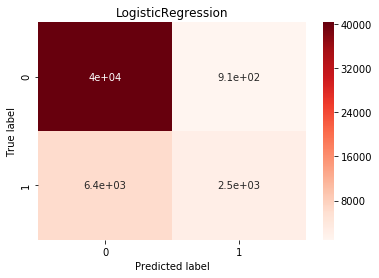

Micro-averaged f1 = 0.85 (treat instances equally)
Macro-averaged f1 = 0.66 (treat classes equally)

 DecisionTreeClassifier
Grid best parameter (max. accuracy):  {'max_depth': 10}
Grid best score (accuracy):  0.8998266666666667
train accuracy= 90.390%
test accuracy= 90.054%
[[39689  1458]
 [ 3509  5344]]


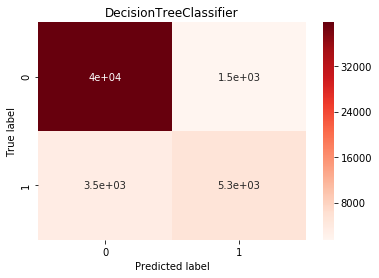

Micro-averaged f1 = 0.90 (treat instances equally)
Macro-averaged f1 = 0.81 (treat classes equally)

 RandomForestClassifier
Grid best parameter (max. accuracy):  {'n_estimators': 250}
Grid best score (accuracy):  0.9041733333333334
train accuracy= 99.551%
test accuracy= 90.350%
[[39295  1852]
 [ 2987  5866]]


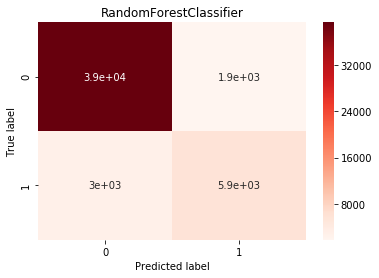

Micro-averaged f1 = 0.90 (treat instances equally)
Macro-averaged f1 = 0.82 (treat classes equally)

 LinearSVC


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Grid best parameter (max. accuracy):  {'C': 1}
Grid best score (accuracy):  0.8492266666666667


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train accuracy= 84.965%
test accuracy= 84.904%
[[40611   536]
 [ 7012  1841]]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


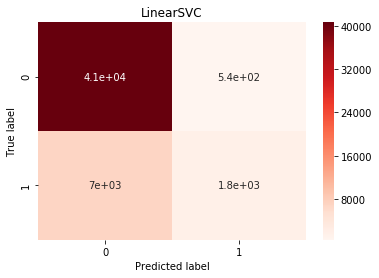

Micro-averaged f1 = 0.85 (treat instances equally)
Macro-averaged f1 = 0.62 (treat classes equally)

 MLP
Grid best parameter (max. accuracy):  {'alpha': 0.01}
Grid best score (accuracy):  0.89854
[[39625  1522]
 [ 3505  5348]]


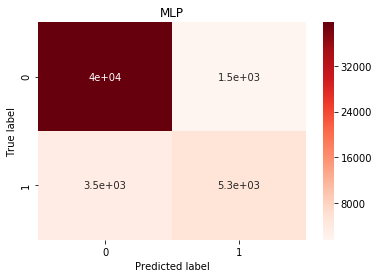

Micro-averaged f1 = 0.90 (treat instances equally)
Macro-averaged f1 = 0.81 (treat classes equally)


In [15]:
run_all_classifiers(X_train_scaled, X_test_scaled, Y_train, Y_test)

### Stage 2: Run multi-class classification of `fraud types` 

In [48]:
# load features for  stage 2: multi-class classification of fraud types 
fn='all_features_fraud.csv'
X_train_scaled_ftype, X_test_scaled_ftype, Y_train_ftype, Y_test_ftype,  scaler_ftype  = prepare_data(fn, stage=1)


X.shape = (35692, 73), Y.shape=(35692,)
X_train.shape=(26769, 73), X_test.shape=(8923, 73),Y_train.shape=(26769,), Y_test.shape=(8923,)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



 LogisticRegression
Grid best parameter (max. accuracy):  {'C': 0.1}
Grid best score (accuracy):  0.7132504015839217
train accuracy= 71.471%
test accuracy= 71.030%
[[4863   31    0    0  249]
 [ 236  523    9    2  201]
 [  68  188   10    3  101]
 [  41   79    3    1   29]
 [1208  135    2    0  941]]


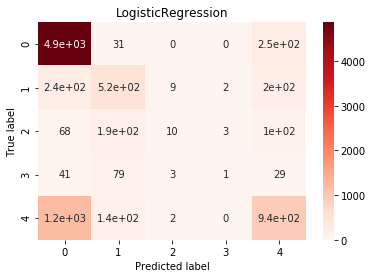

Micro-averaged f1 = 0.71 (treat instances equally)
Macro-averaged f1 = 0.39 (treat classes equally)

 DecisionTreeClassifier
Grid best parameter (max. accuracy):  {'max_depth': 10}
Grid best score (accuracy):  0.7537823601927602
train accuracy= 79.278%
test accuracy= 75.636%
[[4820   42   14    1  266]
 [ 144  654   76   10   87]
 [  46  223   59    4   38]
 [  27   65   24   20   17]
 [ 894  145   38    3 1206]]


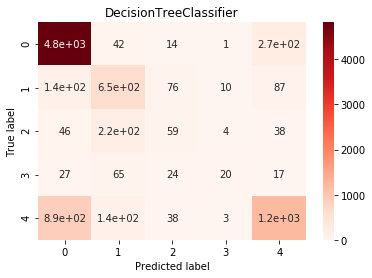

Micro-averaged f1 = 0.76 (treat instances equally)
Macro-averaged f1 = 0.50 (treat classes equally)

 RandomForestClassifier
Grid best parameter (max. accuracy):  {'n_estimators': 250}
Grid best score (accuracy):  0.7652134932197692
train accuracy= 99.847%
test accuracy= 76.275%
[[4790   49    6    2  296]
 [ 122  684   37    8  120]
 [  42  223   41    4   60]
 [  26   87    2   22   16]
 [ 872  132   21    4 1257]]


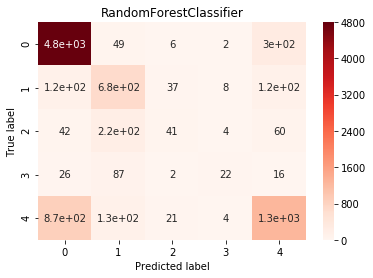

Micro-averaged f1 = 0.76 (treat instances equally)
Macro-averaged f1 = 0.51 (treat classes equally)

 LinearSVC


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Grid best parameter (max. accuracy):  {'C': 1}
Grid best score (accuracy):  0.7033508909559565


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train accuracy= 70.365%
test accuracy= 69.976%


KeyboardInterrupt: 

In [49]:
run_all_classifiers(X_train_scaled_ftype, X_test_scaled_ftype, Y_train_ftype, Y_test_ftype)

## Top relevant features 

#### Stage 0: binary classification 

In [50]:
fn='all_features_binary_20000.csv'
X_train_scaled, X_test_scaled, Y_train, Y_test,  scaler_fraud  = prepare_data(fn, stage=0)

clf_name= 'DecisionTreeClassifier'
print ('\n', clf_name)

clf = DecisionTreeClassifier(max_depth=10)
clf.fit(X_train_scaled, Y_train)

X.shape = (20000, 28), Y.shape=(20000,)
X_train.shape=(15000, 28), X_test.shape=(5000, 28),Y_train.shape=(15000,), Y_test.shape=(5000,)

 DecisionTreeClassifier


/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [51]:
labels_binary = ['genuine', 'fraud']
features_binary= [
    'n_records',
    'has_city_null',
    'n_unique_city',
    'city_at_install',    
    'n_unique_country',
    'country_at_install',
    'n_unique_device_name',
    'device_name_at_install',    
    'n_unique_app_version',
    'app_version_at_install',
    'n_unique_os_version',
    'os_version_at_install',
    'n_unique_isp',
    'isp_at_install',
    'n_akind_event',
    'n_akind_install', 
    'n_akind_reattribution', 
    'n_akind_rejected_install', 
    'n_event_session',
    'n_event_Search', 
    'n_event_Card',
    'n_event_Call', 
    'n_event_Chat_1st_message_sent',
    'n_event_Chat_1st_reply', 
    'n_event_Add',
    'n_event1', # '\\xD0\\xA1\\xD0\\xBE\\xD1\\x85\\xD1\\x80\\xD0\\xB0\\xD0\\xBD\\xD0\\xB5\\xD0\\xBD\\xD0\\xB8\\xD0\\xB5'
    'n_event2', # 'Ð¡Ð¾Ñ\x85Ñ\x80Ð°Ð½ÐµÐ½Ð¸Ðµ'
    'max_n_simultaneous'       
]

len(features_binary), features_binary

(28,
 ['n_records',
  'has_city_null',
  'n_unique_city',
  'city_at_install',
  'n_unique_country',
  'country_at_install',
  'n_unique_device_name',
  'device_name_at_install',
  'n_unique_app_version',
  'app_version_at_install',
  'n_unique_os_version',
  'os_version_at_install',
  'n_unique_isp',
  'isp_at_install',
  'n_akind_event',
  'n_akind_install',
  'n_akind_reattribution',
  'n_akind_rejected_install',
  'n_event_session',
  'n_event_Search',
  'n_event_Card',
  'n_event_Call',
  'n_event_Chat_1st_message_sent',
  'n_event_Chat_1st_reply',
  'n_event_Add',
  'n_event1',
  'n_event2',
  'max_n_simultaneous'])

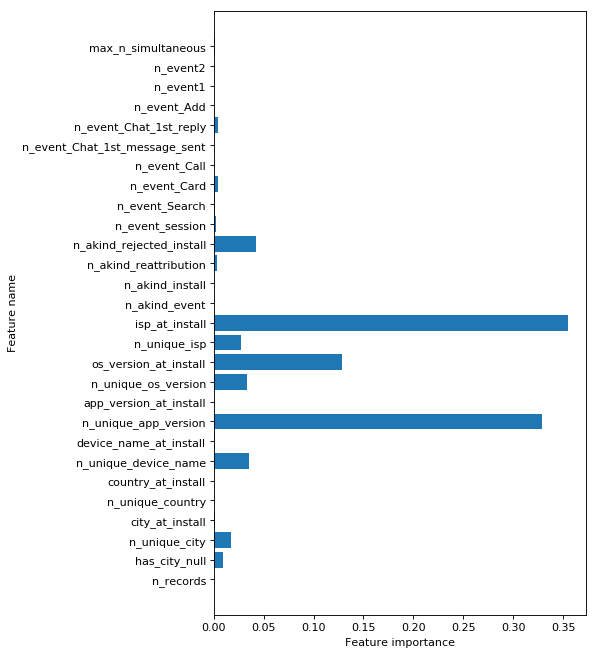

In [52]:
def plot_feature_importances(clf, features):
    plt.figure(figsize=(6, 10), dpi=80)
    c_features = len(features)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), features)
    
plot_feature_importances(clf, features_binary)  

#### Stage 1: Multi class classification 

In [53]:
fn='all_features_fraud.csv'
X_train_scaled_ftype, X_test_scaled_ftype, Y_train_ftype, Y_test_ftype,  scaler_ftype  = prepare_data(fn, stage=1)

clf_name= 'DecisionTreeClassifier'
print ('\n', clf_name)

clf = DecisionTreeClassifier(max_depth=30)
clf.fit(X_train_scaled_ftype, Y_train_ftype)

X.shape = (35692, 73), Y.shape=(35692,)
X_train.shape=(26769, 73), X_test.shape=(8923, 73),Y_train.shape=(26769,), Y_test.shape=(8923,)

 DecisionTreeClassifier


/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=30,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [54]:
features_ftypes= [
    'n_records',
    'has_city_null',
    'n_unique_city',
    'n_changes_city',
    'top_city_1',
    'top_city_2',
    'top_city_3',    
    'city_at_install',        
    'has_country_null',
    'n_unique_country',
    'n_changes_country',
    'top_country_1',
    'top_country_2',
    'top_country_3',    
    'country_at_install',

    'n_unique_device_name',
    'n_changes_device_name',
    'top_device_name_1',
    'top_device_name_2',
    'top_device_name_3',        
    'device_name_at_install',    
    
    'n_unique_app_version',
    'n_changes_app_version',
    'top_app_version_1',
    'top_app_version_2',
    'top_app_version_3',        
    'app_version_at_install',
        
    'n_unique_os_version',
    'n_changes_os_version',
    'top_os_version_1',
    'top_os_version_2',
    'top_os_version_3',        
    'os_version_at_install',
    
    'n_unique_isp',
    'n_changes_isp',
    'top_isp_1',
    'top_isp_2',
    'top_isp_3',        
    'isp_at_install',
    
    'n_akind_event',
    'n_akind_install', 
    'n_akind_reattribution', 
    'n_akind_rejected_install', 
    'n_event_session',
    'n_event_Search', 
    'n_event_Card',
    'n_event_Call', 
    'n_event_Chat_1st_message_sent',
    'n_event_Chat_1st_reply', 
    'n_event_Add',
    'n_event1', # '\\xD0\\xA1\\xD0\\xBE\\xD1\\x85\\xD1\\x80\\xD0\\xB0\\xD0\\xBD\\xD0\\xB5\\xD0\\xBD\\xD0\\xB8\\xD0\\xB5'

    'n_event2', # 'Ð¡Ð¾Ñ\x85Ñ\x80Ð°Ð½ÐµÐ½Ð¸Ðµ'
    
    'n_unique_ip_address',
    'address_at_install',

    'n_event_session_diff_min',
    'n_event_Search_diff_min', 
    'n_event_Card_diff_min',
    'n_event_Call_diff_min', 
    'n_event_Chat_1st_message_sent_diff_min',
    'n_event_Chat_1st_reply_diff_min', 
    'n_event_Add_diff_min',
    'n_event1_diff_min', # '\\xD0\\xA1\\xD0\\xBE\\xD1\\x85\\xD1\\x80\\xD0\\xB0\\xD0\\xBD\\xD0\\xB5\\xD0\\xBD\\xD0\\xB8\\xD0\\xB5'

    'n_event2_diff_min', # 'Ð¡Ð¾Ñ\x85Ñ\x80Ð°Ð½ÐµÐ½Ð¸Ðµ'

    'n_event_session_diff_max',
    'n_event_Search_diff_max', 
    'n_event_Card_diff_max',
    'n_event_Call_diff_max', 
    'n_event_Chat_1st_message_sent_diff_max',
    'n_event_Chat_1st_reply_diff_max', 
    'n_event_Add_diff_max',
    'n_event1_diff_max', # '\\xD0\\xA1\\xD0\\xBE\\xD1\\x85\\xD1\\x80\\xD0\\xB0\\xD0\\xBD\\xD0\\xB5\\xD0\\xBD\\xD0\\xB8\\xD0\\xB5'
    'n_event2_diff_max', # 'Ð¡Ð¾Ñ\x85Ñ\x80Ð°Ð½ÐµÐ½Ð¸Ðµ'

    'max_n_simultaneous'       
]

len(features_ftypes)

73

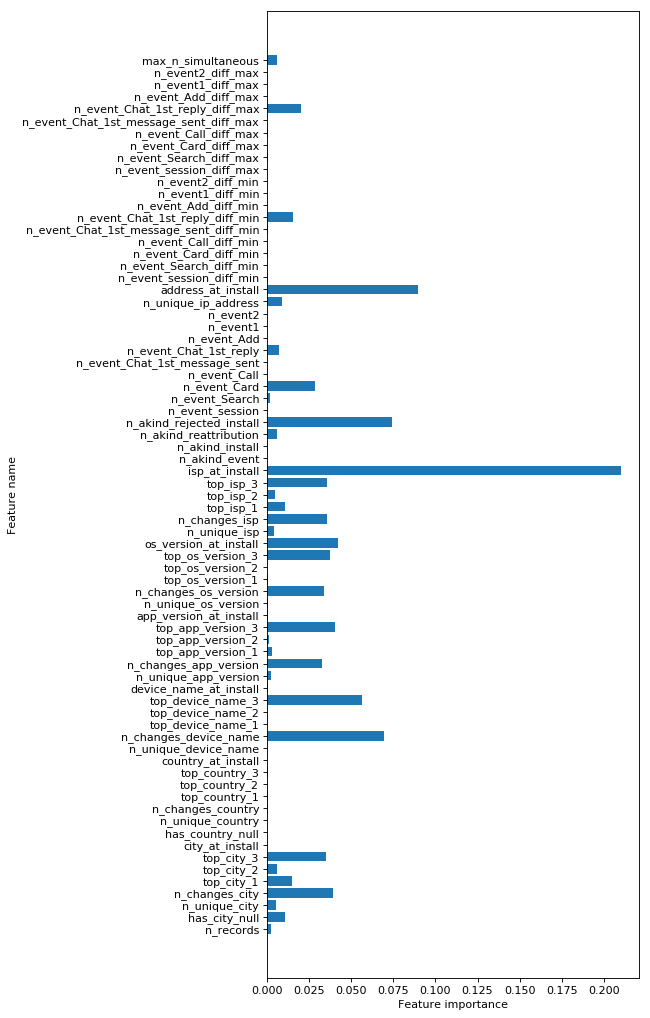

In [55]:
def plot_feature_importances(clf, features):
    plt.figure(figsize=(6, 16), dpi=80)
    c_features = len(features)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), features)
    
plot_feature_importances(clf, features_ftypes) 

## Use conversation as time series 

In [61]:
# df_groupby_cid= df.groupby(cid).count()
# total= len(df_groupby_cid)
df_groupby_cid.sort_values(label, ascending = False).iloc[300:400]

activity_kind  event  device_name  \
conversion_unique_id                                                          
e61f7744e0f37f4ecf70d73c137f7d7c05b4a11e           1318   1207         1318   
683082d3988a47bd2cd7d9bf178863ff2abbc635           1318   1311         1318   
e5c7898331f9d49ab77a3dd5fdd394e40a4879d2           1315   1307         1315   
da0afa0cddb73dccce4bb89bf2a07b728774b901           1314   1314         1314   
f4d7b15148e16bea49fc98cd21e8a8ee6517f819           1311   1311         1311   
a9fb027ff42bc5b372113c33266c7c1be60f4050           1306   1267         1306   
938f54405d01ad98d39e043c012b37eda685e02d           1299   1283         1299   
dc3da5e552072ba5d619327327bbe0cafd971861           1295   1280         1295   
205efc5e0af5df19a668b9243b6b9f771b498812           1295   1293         1295   
6964753d7f168d89b4e3254cbb585849d8d2b034           1295   1275         1295   
5f1d84a3f0800f062e5d11ed28d84f3b226e2ff5           1294   1294         1294   
452b23b1a77307ebdaa526a0651c4484e990574d           1294   1294         1294   
c48157c4aff2a22367e804e7aec2834cc70d3bdb           1293   1293         1293   
0d3757c9a1bafe21b2a93c40d25b2c182b9160aa           1292   1235         1292   
bae6c3532c3fbd78c2ec4be513f45379bbf55876           1292   1289         1292   
d944dccf2a657d10ee7e6beb49bdb066bf64d72e           1291   1277         1291   
a18ddcf1905b824cee667aa6eb357651124fdee2           1290   1290         1290   
e949ac8763c8e37dfd53b91c8dfa7193c88b66ff           1287   1278         1287   
4d0010f625ffbbec4dd97f4cddd703a2e632698e           1287   1283         1287   
8cbe78ca9661d5a389c9a974cccaa25326da5ea0           1285   1246         1285   
31d2cbd2ff9e6e31b010ecd846e21eab32965f81           1285   1274         1285   
d5991fcb70c1d0bd5521ed3a6137f37746f1c510           1284   1284         1284   
f31de57c1b49f01572b39e8d61c6062d8435cdab           1283   1283         1283   
9987d56d91c8c75b940fec95434adbf4dc3f76d0           1280   1276         1280   
8b9cc7174f3e3594b7b5ad06e900b0ea651ef322           1279   1266         1279   
6d2dcd20aa788a5644fbb3c189b96f3b90f4365c           1279   1267         1279   
260f76876f861acd80ef3e224d12c3e76509b6b7           1277   1277         1277   
bd472202c386e32653f767aeca729c1efbf52416           1276   1221         1276   
e7cbdc44497193a91ad3bfe0bef6b732bd9d39a8           1274   1267         1274   
f9a04519b6fd63c28269ed282485707678513df0           1273   1272         1273   
...                                                 ...    ...          ...   
ff857d4d61e9d84dbfa18e9aa0660954135d3d6a           1227   1227         1227   
85278a789b8847a6e77b5940bc4fcc09c0b341b6           1227   1223         1227   
5c02ef1d3a28e0959485f571c6680633fc60c8f5           1226   1215         1226   
fcb702db9e58b75b5da3f80df13819f3e6fc61ac           1224   1191         1224   
058059b3d4f74546753a5ea3305e85fc204ab451           1223   1220         1223   
98b4ca7b3725fd8e0cfbca485c007ab7c45cdabb           1221   1197         1221   
6082536e7ded5cc0e6cfd50c7707a788759f9533           1221   1219         1221   
ec9c7e035660914cf0474f8b943eb6e211944607           1221   1220         1221   
64eb095014746145a19773b48ff3622582282e6f           1216   1211         1216   
c789a22a3d7fd2d89ff0ca7e3d43721179e019cb           1214   1183         1214   
1b436bf9a0ec492347d2e96261bfd74b2e332032           1212   1186         1212   
3e2a3b91f9a68ee5d793820ed11bc227c4bf4a94           1211   1211         1211   
92c3a1d3decd308c7807d3b428f42a45772912d0           1210   1197         1210   
782182dc24b768588e591be1af4a70bf97eb7d3c           1209   1194         1209   
7938adea64a524d5d9b30ce5a30f94b38c2c3901           1207   1207         1207   
75bddb16936ab1ef9ac32644474b591ce2cb0da6           1207   1207         1207   
5349d2390c213c1b2718c3df13eb449f8d7e1b22           1207   1195         1207   
4c2815cb0a5f868bd339ad12a5988b597cd6ea1c           1206   1206         1206   
f74abf517dfae

In [7]:
max_conv_len= 2000 # less than 100 conversation have len > 2000 

### Prepare label encoders

In [55]:
def encode_cols(df):
    '''
    Create and fits LabelEncoder for columns 
    input: df - DataFrame with all data 
    returns: dict of LabelEncoder objects with col names as keys
    '''
    le = {}
    for col in ['city', 'country', akind, 'event','device_name', 'app_version', 'os_version','isp', 'ip_address', ftype]:
        print ('Encode "{}"...'.format(col))
        le[col] = LabelEncoder().fit(df[col].astype(str))

 
    return le

def encode_data(df):    
    print ('Make a copy...')
    df =  df.copy()
    print ('Fill missed values ...')
    df= df.fillna(-1)
   
    col = 'ip_address'    
    print ('Shorten "{}"...'.format(col))
    df[col]= df[col].astype(str).apply(shorten_ip_address)
                
    le = encode_cols(df)

    for col, enc in le.items():    
        print ('Transfrom "{}"...'.format(col))
        df['{}_encoded'.format(col)]= le[col].transform(df[col].astype(str))

#     print ('compute time diff...')
#     df['time_diff'] = df.apply(get_time_diff, axis =1)
    #     scaler= MinMaxScaler()

    return df, le

df_encoded, le = encode_data(df)

Make a copy...
Fill missed values ...
Shorten "ip_address"...
Encode "city"...
Encode "country"...
Encode "activity_kind"...
Encode "event"...
Encode "device_name"...
Encode "app_version"...
Encode "os_version"...
Encode "isp"...
Encode "ip_address"...
Encode "fraud_type"...
Transfrom "city"...
Transfrom "country"...
Transfrom "activity_kind"...
Transfrom "event"...
Transfrom "device_name"...
Transfrom "app_version"...
Transfrom "os_version"...
Transfrom "isp"...
Transfrom "ip_address"...
Transfrom "fraud_type"...


### Convert data into 3d format for further model training

In [16]:
import pickle
def get_time_diff(row):
    '''compute total seconds between installed_at and created_at values'''
    installed_at= dt.datetime.strptime(row['installed_at'], '%Y-%m-%d %H:%M:%S')
    created_at= dt.datetime.strptime(row['created_at'], '%Y-%m-%d %H:%M:%S')
    return (created_at- installed_at).total_seconds()


# def encode_data(df_conv, le):    
#     '''add columns with encoded values for columns selected to encode (keys in le)'''
#     df_conv= df_conv.sort_values('created_at')    
#     df_conv= df_conv.fillna(-1)
#     df_conv['ip_address']= df_conv['ip_address'].astype(str).apply(shorten_ip_address)
#     for col, enc in le.items():    
#         df_conv['{}_encoded'.format(col)]= df_conv[col].apply(lambda x: le[col].transform([x])[0] if x != -1 else -1) 
#     df_conv['time_diff'] = df_conv.apply(get_time_diff, axis =1 )
#     return df_conv

def select_features(df_conv):
    '''selects just necessary columns x and y'''
    df_conv= df_conv.head(max_conv_len)
    
    x= df_conv[[ 
            'city_encoded',
            'country_encoded',
            'activity_kind_encoded',
            'event_encoded',
            'device_name_encoded',
            'app_version_encoded',
            'os_version_encoded',
            'isp_encoded', 
            'ip_address_encoded', 
            'time_diff', 
        ]].values

    y = df_conv[['fraud_type_encoded']].values[0]
    
#     #     zero pad
#     n_vars = x_train.shape[1]
#     x_pad = np.zeros((max_conv_len, n_vars))
    
#     current_len = x_train.shape[0]
#     x_pad[:current_len] = x_train
#     x_train= np.expand_dims(x_pad, axis=0)

    return x, y
        
    
def convert_data(df, total, le):
    '''convert data to 3d format of encoded values for further model training'''
    iter_number=0 
    step = 1000
    start_time = dt.datetime.fromtimestamp(time.time())
#     X_train = Y_train =  None
    print ('Groupby {}... This may take extra time at first iteration.'.format(cid))
    
    X_= []
    Y= []

    for conv_id, df_conv in df.groupby(cid):  

        if iter_number==0:
            print ('Iterate for each {}...'.format(cid))
        
        df_conv= df_conv.sort_values('created_at')    
        
        # compute time diff...
        df_conv['time_diff'] = df_conv.apply(get_time_diff, axis =1)
        
        x, y = select_features(df_conv)                

        X.append(x)
        Y.append(y)
  

        iter_number+=1 
        # print progress
        if iter_number%step==0:            
            iter_time = dt.datetime.fromtimestamp(time.time())
            iter_duration = iter_time - start_time
            start_time = iter_time
            estimated = (total- iter_number)/step * iter_duration.seconds 

            print('{} of {} [{:.4%}] finished  at {} duration = {}s , estimated duration = {}'.format(
                iter_number,
                total,
                iter_number/total, 
                iter_time.strftime('%H:%M:%S'),
                iter_duration.seconds,
                str(dt.timedelta(seconds=estimated))))
            
        # save intermediate results              
        if iter_number%(step*20)==0:
            data = (X, Y)
            fn = 'data_train_pickle_{}'.format(iter_number)
            with open(fn, "wb") as f:
                pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        
#         if iter_number>2000:
#             break
    return X, Y



In [84]:
X, Y = convert_data(df_encoded, total, le)

Groupby conversion_unique_id... This may take extra time at first iteration.
Iterate for each conversion_unique_id...
1000 of 936479 [0.1068%] finished  at 14:56:46 duration = 54s , estimated duration = 14:01:55.866000
2000 of 936479 [0.2136%] finished  at 14:56:51 duration = 4s , estimated duration = 1:02:17.916000
3000 of 936479 [0.3203%] finished  at 14:56:55 duration = 4s , estimated duration = 1:02:13.916000
4000 of 936479 [0.4271%] finished  at 14:56:59 duration = 4s , estimated duration = 1:02:09.916000
5000 of 936479 [0.5339%] finished  at 14:57:09 duration = 10s , estimated duration = 2:35:14.790000
6000 of 936479 [0.6407%] finished  at 14:57:14 duration = 4s , estimated duration = 1:02:01.916000
7000 of 936479 [0.7475%] finished  at 14:57:18 duration = 4s , estimated duration = 1:01:57.916000
8000 of 936479 [0.8543%] finished  at 14:57:22 duration = 4s , estimated duration = 1:01:53.916000
9000 of 936479 [0.9610%] finished  at 14:57:26 duration = 4s , estimated duration = 1:0

NameError: name 'X_train' is not defined

In [2]:
import pickle
def prepare_data_for_deep_learn(fn, prepare_binary=True):
    with open(fn, 'rb') as f:
        data = pickle.load(f)
    X, Y= data
    Y = [y[0][0] for y in Y] # Tempporary fix of mistake at getting features 
    print ('len(X) = {:,}, len(Y)={:,}'.format(len(X),len(Y)))

    n_vars = X[0].shape[1]

    X_input = np.zeros((n_samples, max_conv_len, n_vars))
    for i in range(n_samples):
        target_len= X[i].shape[0] if X[i].shape[0] <= max_conv_len else max_conv_len
        X_input[i,:target_len,:X[i].shape[1]]= X[i][:target_len, :]             

        
    Y_input = np.array(Y)[:n_samples]
    if prepare_binary:
        Y_input[Y_input>0] =1
    else:
        indices= Y_input>0
        X_input = X_input[indices] 
        Y_input = Y_input[indices] 


    # split to train/test 
    X_train, X_test, Y_train, Y_test=  train_test_split(X_input, Y_input, random_state=2019, test_size= 0.1)
    print ('X_train.shape = {}, X_test.shape = {}, Y_train.shape = {}, Y_test.shape = {}'.format(
        X_train.shape, X_test.shape, Y_train.shape,Y_test.shape))

#     # scale      
#     scaler = StandardScaler()
#     X_train_scaled= scaler.fit_transform(X_train)
#     X_test_scaled= scaler.transform(X_test)

#     return X_train_scaled, X_test_scaled, Y_train, Y_test, scaler
    return X_train, X_test, Y_train, Y_test


In [147]:
fn= 'data_train_pickle_920000'
max_conv_len= 500 # 
n_samples= 300000 # 

X_train, X_test, Y_train, Y_test  = prepare_data_for_deep_learn(fn)

len(X) = 920,000, len(Y)=920,000
X_train.shape = (270000, 500, 10), X_test.shape = (30000, 500, 10), Y_train.shape = (270000,), Y_test.shape = (30000,)


## Binary classification with lstm 

In [11]:
import tensorflow as tf 

In [83]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(max_conv_len, 10)),
    tf.keras.layers.Dense(10, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('happy') and 1 for the other ('sad')
    tf.keras.layers.Dense(1, activation='sigmoid')

])

In [84]:
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(X_train, Y_train, epochs=3, batch_size=256, validation_data=(X_test, Y_test), shuffle=False)

# save model 
model.save("binary_lstm.h5")

Train on 270000 samples, validate on 30000 samples
Epoch 1/3
270000/270000 [==============================] - 777s 3ms/sample - loss: 0.1899 - acc: 0.9561 - val_loss: 0.1839 - val_acc: 0.9552
Epoch 2/3
270000/270000 [==============================] - 774s 3ms/sample - loss: 0.1800 - acc: 0.9564 - val_loss: 0.1837 - val_acc: 0.9552
Epoch 3/3
270000/270000 [==============================] - 768s 3ms/sample - loss: 0.1797 - acc: 0.9564 - val_loss: 0.1835 - val_acc: 0.9552


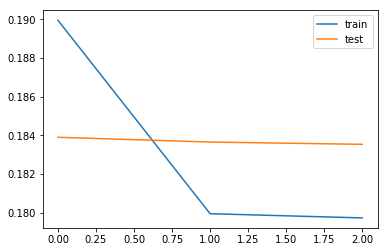

In [88]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Multi-class classification with lstm 

In [5]:
# fn= 'data_train_pickle_920000'
max_conv_len= 500 # 
n_samples= 920000 # 

X_train, X_test, Y_train, Y_test  = prepare_data_for_deep_learn(fn,prepare_binary= False)

len(X) = 920,000, len(Y)=920,000
X_train.shape = (36243, 500, 10), X_test.shape = (4027, 500, 10), Y_train.shape = (36243,), Y_test.shape = (4027,)


In [15]:

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(max_conv_len, 10)),
    tf.keras.layers.Dense(10, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('happy') and 1 for the other ('sad')
    tf.keras.layers.Dense(6, activation='softmax')
])
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

import keras 
from keras.utils import to_categorical
Y_cat_train = to_categorical(Y_train)
Y_cat_test = to_categorical(Y_test)

# fit model
# history = model.fit(X_train, Y_train, epochs=3, batch_size=256, validation_data=(X_test, Y_test), shuffle=False)
history = model.fit(X_train, Y_cat_train, epochs=20, batch_size=256, validation_data=(X_test, Y_cat_test), shuffle=False)

# save model 
model.save("ftype_lstm.h5")


Train on 36243 samples, validate on 4027 samples
Epoch 1/20
36243/36243 [==============================] - 104s 3ms/sample - loss: 1.3928 - acc: 0.4786 - val_loss: 1.1773 - val_acc: 0.5893
Epoch 2/20
36243/36243 [==============================] - 103s 3ms/sample - loss: 1.1606 - acc: 0.5675 - val_loss: 1.1068 - val_acc: 0.5893
Epoch 3/20
36243/36243 [==============================] - 103s 3ms/sample - loss: 1.1970 - acc: 0.5567 - val_loss: 1.1126 - val_acc: 0.5890
Epoch 4/20
36243/36243 [==============================] - 102s 3ms/sample - loss: 1.1228 - acc: 0.5674 - val_loss: 1.0902 - val_acc: 0.5890
Epoch 5/20
36243/36243 [==============================] - 103s 3ms/sample - loss: 1.1166 - acc: 0.5674 - val_loss: 1.0820 - val_acc: 0.5890
Epoch 6/20
36243/36243 [==============================] - 102s 3ms/sample - loss: 1.1206 - acc: 0.5674 - val_loss: 1.0923 - val_acc: 0.5890
Epoch 7/20
36243/36243 [==============================] - 102s 3ms/sample - loss: 1.1185 - acc: 0.5674 - val_lo

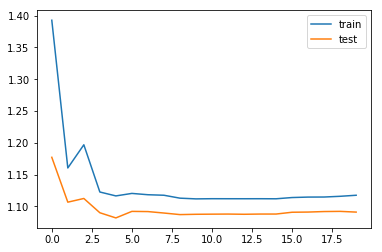

In [17]:
import matplotlib.pyplot as plt 
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Get auto-encoded features 

### Load trained model 

In [57]:
import tensorflow as tf 
from tensorflow.keras.models import load_model
fn_model = 'ftype_lstm.h5'
model_ftype = load_model(fn_model)

W0903 15:37:15.321833 140659059598720 deprecation.py:506] From /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0903 15:37:15.322765 140659059598720 deprecation.py:506] From /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0903 15:37:15.323653 140659059598720 deprecation.py:506] From /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.in

In [58]:
model_ftype.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                19200     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 66        
Total params: 19,916
Trainable params: 19,916
Non-trainable params: 0
_________________________________________________________________


### Build encoder model 

In [59]:
encoder_model = tf.keras.models.Model(inputs = model_ftype.input, outputs = model_ftype.layers[1].output)

In [69]:
import pickle
def prepare_data_for_deep_learn(fn, prepare_binary=True, split= True):
    with open(fn, 'rb') as f:
        data = pickle.load(f)
    X, Y= data
    Y = [y[0][0] for y in Y] # Tempporary fix of mistake at getting features 
    print ('len(X) = {:,}, len(Y)={:,}'.format(len(X),len(Y)))

    n_vars = X[0].shape[1]

    X_input = np.zeros((n_samples, max_conv_len, n_vars))
    for i in range(n_samples):
        target_len= X[i].shape[0] if X[i].shape[0] <= max_conv_len else max_conv_len
        X_input[i,:target_len,:X[i].shape[1]]= X[i][:target_len, :]             

        
    Y_input = np.array(Y)[:n_samples]
    if prepare_binary:
        Y_input[Y_input>0] =1
    else:
        indices= Y_input>0
        X_input = X_input[indices] 
        Y_input = Y_input[indices] 


    if split : 
        # split to train/test 

        X_train, X_test, Y_train, Y_test=  train_test_split(X_input, Y_input, random_state=2019, test_size= 0.1)
        print ('X_train.shape = {}, X_test.shape = {}, Y_train.shape = {}, Y_test.shape = {}'.format(
            X_train.shape, X_test.shape, Y_train.shape,Y_test.shape))

        return X_train, X_test, Y_train, Y_test
    else: 
        return X_input, Y_input
    

### Load encoded data 

In [67]:
fn= 'data_train_pickle_920000'
max_conv_len= 500 # 
n_samples= 300000 # 

X_train, X_test, Y_train, Y_test  = prepare_data_for_deep_learn(fn,prepare_binary=False)

len(X) = 920,000, len(Y)=920,000
X_train.shape = (11798, 500, 10), X_test.shape = (1311, 500, 10), Y_train.shape = (11798,), Y_test.shape = (1311,)


### Encode series to features 

In [68]:
auto_encoded_features  = encoder_model.predict(X_train[:1000])
print (auto_encoded_features.shape)
auto_encoded_features[300]

(1000, 10)


array([1.39229 , 0.      , 0.      , 0.      , 0.      , 3.811425,
       0.      , 0.      , 0.      , 2.605663], dtype=float32)

## Cluster the data using unsupervised learing 


In [73]:
# use only fraud conversations from part of all data 
max_conv_len= 500 # 
n_samples= 500000 # 

X, Y  = prepare_data_for_deep_learn(fn,prepare_binary=False, split=False)

len(X) = 920,000, len(Y)=920,000


In [74]:
X.shape

(21978, 500, 10)

In [75]:
X_auto_encoded = encoder_model.predict(X)

In [76]:
X_auto_encoded.shape

(21978, 10)

## Convert data to 2 dims for visualization

In [93]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

#### PCA

In [131]:
def comress_score(X, X_approximate):
    return np.sum(np.apply_along_axis (np.linalg.norm,1, (X-X_approximate))**2)/\
        np.sum(np.apply_along_axis (np.linalg.norm,1, X)**2)

pca = PCA(n_components=3)
Z_pca = pca.fit_transform(X_auto_encoded)
X_approximate = pca.inverse_transform(Z_pca)
print ('comress_score = {} [expected to be less than 0.05]'.format(comress_score(X_auto_encoded, X_approximate)))
print('pca.explained_variance_ratio_: {}'.format(pca.explained_variance_ratio_))

In [116]:

def comress_score(X, X_approximate):
    return np.sum(np.apply_along_axis (np.linalg.norm,1, (X-X_approximate))**2)/\
        np.sum(np.apply_along_axis (np.linalg.norm,1, X)**2)

pca = PCA(n_components=3)
Z_pca = pca.fit_transform(X_auto_encoded)
X_approximate = pca.inverse_transform(Z_pca)
print ('comress_score = {} [expected to be less than 0.05]'.format(comress_score(X_auto_encoded, X_approximate)))
print('pca.explained_variance_ratio_: {}'.format(pca.explained_variance_ratio_))



comress_score = 1.9983193851658143e-05 [expected to be less than 0.05]
pca.explained_variance_ratio_: [9.9208331e-01 7.6141753e-03 9.4133291e-05]


#### TSNE

In [113]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
Z_tsne = tsne.fit_transform(X_auto_encoded)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 21978 samples in 0.592s...
[t-SNE] Computed neighbors for 21978 samples in 6.632s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21978
[t-SNE] Computed conditional probabilities for sample 2000 / 21978
[t-SNE] Computed conditional probabilities for sample 3000 / 21978
[t-SNE] Computed conditional probabilities for sample 4000 / 21978
[t-SNE] Computed conditional probabilities for sample 5000 / 21978
[t-SNE] Computed conditional probabilities for sample 6000 / 21978
[t-SNE] Computed conditional probabilities for sample 7000 / 21978
[t-SNE] Computed conditional probabilities for sample 8000 / 21978
[t-SNE] Computed conditional probabilities for sample 9000 / 21978
[t-SNE] Computed conditional probabilities for sample 10000 / 21978
[t-SNE] Computed conditional probabilities for sample 11000 / 21978
[t-SNE] Computed conditional probabilities for sample 12000 / 21978
[t-SNE] Computed conditional probabilities for sa

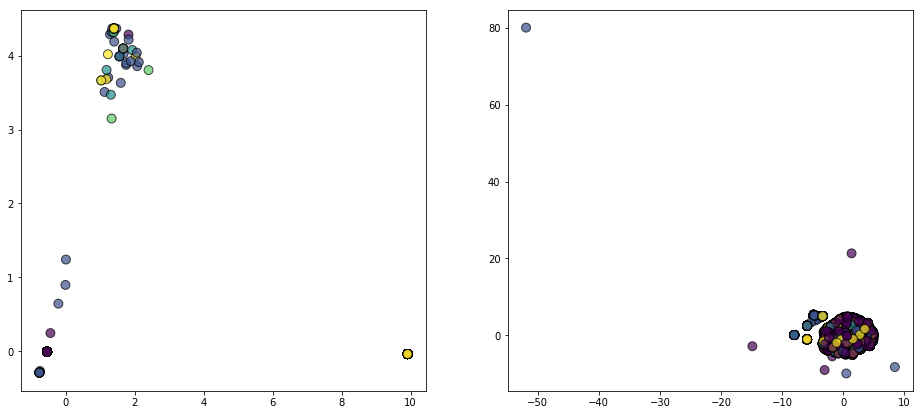

In [135]:
color= Y
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
ax1.scatter(Z_pca[:,0], Z_pca[:,1], s= 80, c= color,  edgecolor = 'black', label='negative', alpha = 0.7)
ax2 = plt.subplot(1, 2, 2)
ax2.scatter(Z_tsne[:,0], Z_tsne[:,1], s= 80, c= color,  edgecolor = 'black', label='negative', alpha = 0.7)
plt.show()




#### Conclusion:  Let's use PCA 

### DBSCAN

In [139]:
from sklearn.cluster import DBSCAN

def apply_db_scan(points, eps):
    dbscan = DBSCAN(eps=eps, min_samples=2, ).fit(points) # default eps=0.5, min_samples=5
    # dbscan = DBSCAN(min_samples=6).fit(points)
    predicted = dbscan.labels_
    n_clusters_and_noice = len(np.unique(predicted))-1
    print ('eps = {}: n_clusters_and_noice ={}\n'.format(eps, n_clusters_and_noice))

    predicted[np.where(predicted == -1)] = n_clusters_and_noice
    return predicted 

predicted={}
for i,eps in enumerate([0.08, 0.81, 0.9, 1, 5]):
    predicted[i]  =  apply_db_scan(X_auto_encoded, eps=eps)


eps = 0.08: n_clusters_and_noice =8

eps = 0.81: n_clusters_and_noice =4

eps = 0.9: n_clusters_and_noice =3

eps = 1: n_clusters_and_noice =2

eps = 5: n_clusters_and_noice =1



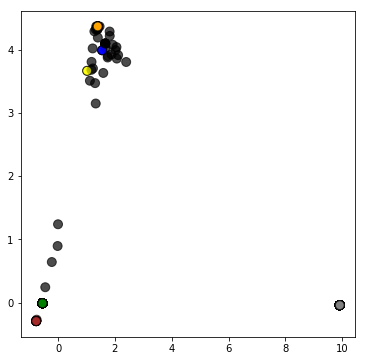

In [140]:
def visualize_clusters(Z_pca, predicted):
    plt.figure(figsize=(6,6))
    colors=  np.array(['green','grey', 'orange', 'brown', 'blue', 'yellow'])
    colors= np.r_[colors, np.array(['black']*100)]
    plt.scatter(Z_pca[:,0], Z_pca[:,1], s= 80, c= colors[predicted],  edgecolor = 'black', label='negative', alpha = 0.7)
    plt.show()

visualize_clusters(Z_pca,predicted[0])


### Agglomerative clustering

In [126]:
from sklearn.cluster import AgglomerativeClustering

In [145]:
clf = AgglomerativeClustering(n_clusters=8, linkage= 'ward')  
predicted = clf.fit_predict(X_auto_encoded)

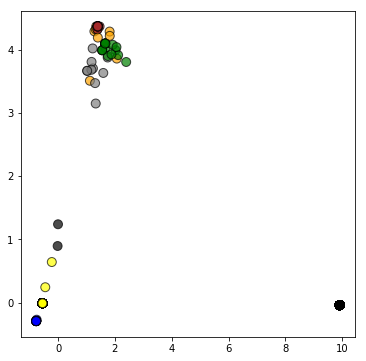

In [146]:
visualize_clusters(Z_pca,predicted)

### K-means

In [142]:
from sklearn.cluster import KMeans
clf = KMeans(n_clusters=8)  
predicted = clf.fit_predict(X_auto_encoded)

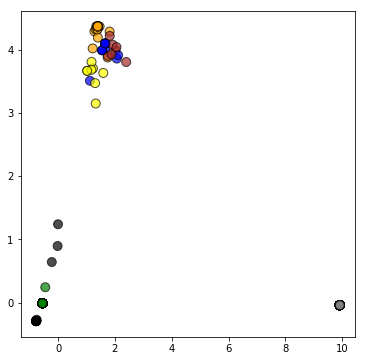

In [143]:
visualize_clusters(Z_pca,predicted)